# ML Models LMP1210

In [10]:
import concurrent.futures
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import optuna
from scipy import stats

In [11]:
combined_df = "combined_output.csv"
combined_data = pd.read_table(combined_df, header=None,delimiter=",")

selected_cols = combined_data.iloc[:, [0, 2, 4]]

cols_after_five = combined_data.iloc[:, 5:]

# Concatenate the two selections
combined_selection = pd.concat([selected_cols, cols_after_five], axis=1)

X = combined_selection.iloc[:, 2:].astype(float)
y = combined_selection.iloc[:, 1].astype(float)
# print(combined_selection.iloc[:, 1])


### New Code with parallelization

### Old Code

In [ ]:

##########################################
### NESTED FIVEFOLDER CROSS VALIDATION ###
##########################################

# create dataframe to store results
fold_models_df = pd.DataFrame(columns=['Fold', 'Pearson'])

# initialize the outer folds (5 folds, 80% train, 20% test)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# loop through each of the outer five folds
fold = 1
for train_index, test_index in outer_cv.split(X):

    print("********** STARTING FOLD", fold)

    X_train_outer, X_test_outer = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # initialize variables to store best model parameters
    best_model_params = None
    best_pearsons = 0

    # initialize the inner folds (5 folds, 80% train, 20% validation)
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # loop through each of the inner five folds
    inner_fold = 1
    for inner_train_index, inner_val_index in inner_cv.split(X_train_outer):

        print("***** STARTING INNER FOLD", inner_fold)
        
        X_train_inner, X_val = X_train_outer.iloc[inner_train_index, :], X_train_outer.iloc[inner_val_index, :]
        y_train_inner, y_val = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]


        ###############################################
        ### OPTIMIZE PARAMETERS WITH VALIDATION SET ###
        ###############################################


        def objective(trial):
            # hyperparameters to optimize
            n_estimators = trial.suggest_int(name = "n_estimators", low = 50, high = 500, step = 50)
            max_features = trial.suggest_categorical(name = "max_features", choices = ["log2", "sqrt"])
            min_samples_split = trial.suggest_int(name = "min_samples_split", low = 2, high = 20, step = 2)
            min_samples_leaf = trial.suggest_int(name = "min_samples_leaf", low = 1, high = 10, step = 1)

            # initialize random forest regressor
            regr = RandomForestRegressor(
                random_state = 0,
                n_estimators=n_estimators,
                max_features=max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf
            )

            # fit random forest regressor to validation set
            regr.fit(X_train_inner, y_train_inner)

            # get predicted values for validation set
            y_pred = regr.predict(X_val)

            # get pearson's
            res = stats.pearsonr(y_pred, y_val)

            return res[0]

        # run optuna to optimize parameters
        print("-----Beginning Optimization")
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=1000)

        print("Outer fold:")
        print(fold)

        print("Inner fold:")
        print(inner_fold)

        print("Best trial: ")
        print(study.best_params)

        print("Best Pearson's: ")
        print(study.best_value)

        # update best result
        if study.best_value > best_pearsons:
            best_pearsons = study.best_value
            best_model_params = study.best_params

        inner_fold += 1


    ############################################
    ### TEST MODEL WITH OPTIMIZED PARAMETERS ###
    ############################################

    print("-----Beginning Testing")

    # initialize random forest regressor with optimized parameters
    regr = RandomForestRegressor(random_state = 0, **best_model_params)

    # fit random forest regressor to training data
    regr.fit(X_train_outer, y_train_outer)

    # get predicted values for x_test
    y_pred = regr.predict(X_test_outer)

    # get pearson's
    pearson_fold = stats.pearsonr(y_pred, y_test_outer)

    # save results to dataframe
    fold_models_df = fold_models_df.append({'Fold': fold, 'Pearson': pearson_fold}, ignore_index=True)

    fold += 1

# save data frames
fold_models_df.to_csv('rf_outerfold.csv', index=False)


[I 2024-06-12 17:53:30,248] A new study created in memory with name: no-name-f10000bc-78dc-4803-9815-2d3cf19c37e2


********** STARTING FOLD 1
***** STARTING INNER FOLD 1
-----Beginning Optimization


[I 2024-06-12 17:53:30,574] Trial 0 finished with value: 0.1247577828855058 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.1247577828855058.
[I 2024-06-12 17:53:30,701] Trial 1 finished with value: -0.05817411262997641 and parameters: {'n_estimators': 50, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.1247577828855058.
[I 2024-06-12 17:53:31,277] Trial 2 finished with value: 0.11144676228867598 and parameters: {'n_estimators': 300, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.1247577828855058.
[I 2024-06-12 17:53:31,587] Trial 3 finished with value: 0.11997505387853466 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.1247577828855058.
[I 2024-06-12 17:53:32,252] Trial 4 finished with value: 0.1

Outer fold:
1
Inner fold:
1
Best trial: 
{'n_estimators': 50, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 6}
Best Pearson's: 
0.16354234432339132
***** STARTING INNER FOLD 2
-----Beginning Optimization


[I 2024-06-12 17:53:38,937] Trial 0 finished with value: 0.12212434303478302 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.12212434303478302.
[I 2024-06-12 17:53:39,147] Trial 1 finished with value: 0.16405404714813304 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.16405404714813304.
[I 2024-06-12 17:53:39,990] Trial 2 finished with value: 0.047521612662719134 and parameters: {'n_estimators': 450, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.16405404714813304.
[I 2024-06-12 17:53:40,114] Trial 3 finished with value: 0.1456835560092259 and parameters: {'n_estimators': 50, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.16405404714813304.
[I 2024-06-12 17:53:40,612] Trial 4 finished with value:

Outer fold:
1
Inner fold:
2
Best trial: 
{'n_estimators': 50, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 7}
Best Pearson's: 
0.1994351287840111
-----Beginning Testing
********** STARTING FOLD 2
***** STARTING INNER FOLD 1
-----Beginning Optimization


[I 2024-06-12 17:53:46,939] Trial 0 finished with value: 0.18605584273671275 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.18605584273671275.
[I 2024-06-12 17:53:47,760] Trial 1 finished with value: 0.2846204125014803 and parameters: {'n_estimators': 400, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.2846204125014803.
[I 2024-06-12 17:53:48,480] Trial 2 finished with value: 0.2873541302205111 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.2873541302205111.
[I 2024-06-12 17:53:48,604] Trial 3 finished with value: 0.10749799408425903 and parameters: {'n_estimators': 50, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.2873541302205111.
[I 2024-06-12 17:53:49,445] Trial 4 finished with value: 0

# test

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:

# specify file paths
train_df = "train_df.tsv"
test_df = "test_df.tsv"
train_auc = "sample_training_data.txt"
test_auc = "sample_test_data.txt"

#I renamed this julia sorry
# train_auc = "training_data.txt"
# test_auc = "test_data.txt"


In [ ]:
# read in binary feature files
df = pd.read_table(train_df)
X_test = pd.read_table(test_df)

# load in drug response data
y_train = pd.read_table(train_auc, header = None)
y_train = y_train.iloc[:, 2]

y_test = pd.read_table(test_auc, header = None)
y_test = y_test.iloc[:, 2]

# merge training into one dataframe for split
df['auc'] = y_train.values

# shuffle dataframe so split will be random
df = df.sample(frac=1, random_state=0)

# split data so that we have train (64%), validate (16%) and test (20%) - test already 20%
df_train = df[:int(0.8 * df.shape[0])] #first 80%
df_validate = df[int(0.8 * df.shape[0]):] #last 20%

len_features = X_test.shape[1]

# extract X and y
X_train = df_train.iloc[:,:len_features]
y_train = df_train.iloc[:,len_features:df_train.shape[1]].values.ravel()
X_validate = df_validate.iloc[:,:len_features]
y_validate = df_validate.iloc[:,len_features:df_validate.shape[1]].values.ravel()


In [ ]:
###############################################
### OPTIMIZE PARAMETERS WITH VALIDATION SET ###
###############################################


def objective(trial):
    # hyperparameters to optimize
    n_estimators = trial.suggest_int(name = "n_estimators", low = 50, high = 500, step = 50)
    max_features = trial.suggest_categorical(name = "max_features", choices = ["log2", "sqrt"])
    min_samples_split = trial.suggest_int(name = "min_samples_split", low = 2, high = 20, step = 2)
    min_samples_leaf = trial.suggest_int(name = "min_samples_leaf", low = 1, high = 10, step = 1)

    # initialize random forest regressor
    regr = RandomForestRegressor(
        random_state = 0,
        n_estimators=n_estimators,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # fit random forest regressor to validation set
    regr.fit(X_validate, y_validate)

    # get mse
    y_pred = regr.predict(X_test)
    mse = mean_squared_error(y_pred, y_test)
    print("MSE: ", mse)

    # get pearson's
    res = stats.pearsonr(y_pred, y_test)
    return res[0]


# run optuna to optimize parameters
print("-----Beginning Optimization")
study = optuna.create_study()
study.optimize(objective, n_trials=700, show_progress_bar=True)

print("Best trial: ")
print(study.best_params)

[I 2024-04-04 00:54:54,707] A new study created in memory with name: no-name-37824b36-0288-4983-849f-3b67822cb3ff


-----Beginning Optimization


  0%|          | 0/700 [00:00<?, ?it/s]

MSE:  0.03568103164228829
[I 2024-04-04 00:54:55,174] Trial 0 finished with value: 0.19110850876441018 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.19110850876441018.
MSE:  0.03654016944446061
[I 2024-04-04 00:54:55,431] Trial 1 finished with value: 0.20460623248406504 and parameters: {'n_estimators': 150, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.19110850876441018.
MSE:  0.03535091723051959
[I 2024-04-04 00:54:56,591] Trial 2 finished with value: 0.21261848483051035 and parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.19110850876441018.
MSE:  0.03511736255589339
[I 2024-04-04 00:54:57,628] Trial 3 finished with value: 0.22674566271324503 and parameters: {'n_estimators': 400, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 1}.

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
#############################################
### RANDOM FOREST 5-FOLD CROSS VALIDATION ###
#############################################

# best parameters from optuna
best_params = {'n_estimators': 500, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 9}

# combine data
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# create 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# initialize arrays to store MSE and Pearson's correlation
mse = []
corr = []

# create dataframe to store results
res_rf = pd.DataFrame(columns=['Fold', 'MSE', 'Pearson'])

print("-----Beginning 5-Fold Cross-Validation on Train and Test Data")

i = 1
for train_index, test_index in kf.split(X):

    print("Starting Fold", i)

    # Split data into train and test sets
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # initialize random forest regressor with optimized parameters
    regr = RandomForestRegressor(random_state=0, **best_params)

    # Fit random forest regressor to training data
    regr.fit(X_train_fold, y_train_fold)

    # get predicted values from test dataset
    y_pred = regr.predict(X_test_fold)

    # MSE
    mse_fold = mean_squared_error(y_pred, y_test_fold)
    print("MSE: ", mse_fold)
    mse.append(mse_fold)

    # Pearson's correlation coefficient
    pearson_fold = stats.pearsonr(y_pred, y_test_fold)[0]
    print("Pearson's: ", pearson_fold)
    corr.append(pearson_fold)

    # save results to dataframe
    row = pd.DataFrame([[i, mse_fold, pearson_fold]], columns=['Fold', 'MSE', 'Pearson'])
    res_rf = pd.concat([res_rf, row])

    i += 1

# save data frame
res_rf.to_csv('rf_kfold.csv', index=False)

# average scores across all folds
mean_mse_rf = np.mean(mse)
sd_mse_rf = np.std(mse)
mean_pearson_rf = np.mean(corr)
sd_pearson_rf = np.std(corr)

print("Average Model MSE: ", mean_mse_rf)
print("Average Model Pearson's: ", mean_pearson_rf)

-----Beginning 5-Fold Cross-Validation on Train and Test Data
Starting Fold 1
MSE:  0.03271656585481935
Pearson's:  0.30896686832298487
Starting Fold 2
MSE:  0.02963829746185917
Pearson's:  0.42596655016376495
Starting Fold 3
MSE:  0.03255289260391583
Pearson's:  0.4422159315749397
Starting Fold 4
MSE:  0.03207999466890853
Pearson's:  0.39122439836748313
Starting Fold 5
MSE:  0.03417094871025036
Pearson's:  0.3233455398846384
Average Model MSE:  0.03223173985995065
Average Model Pearson's:  0.3783438576627622


In [ ]:
######## show the model
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source

print("-----Beginning Training")

# initialize random forest regressor with optimized parameters
regr = RandomForestRegressor(
        random_state = 0,
        **study.best_params
    )

# fit random forest regressor to training data
test = regr.fit(X_train, y_train)


model = test
feature_columns = X_train.columns

# Visualize the tree
graph = Source(export_graphviz(model, out_file=None, feature_names=feature_columns, filled=True))
graph.format = 'png'
graph.render('dt', view=True)

-----Beginning Training


AttributeError: 'RandomForestRegressor' object has no attribute 'tree_'

In [ ]:
###########################################
### ELASTIC NET 5-FOLD CROSS VALIDATION ###
###########################################

# best parameters from optuna
best_params = {'alpha': 1.0, 'l1_ratio': 0.0, 'max_iter': 1400}

# combine data
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# create 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# initialize arrays to store MSE and Pearson's correlation
mse = []
corr = []

# create dataframe to store results
res_en = pd.DataFrame(columns=['Fold', 'MSE', 'Pearson'])

print("-----Beginning 5-Fold Cross-Validation on Train and Test Data")

i = 1
for train_index, test_index in kf.split(X):

    print("Starting Fold", i)

    # Split data into train and test sets
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # initialize random forest regressor with optimized parameters
    regr = ElasticNet(random_state=0, **best_params)

    # Fit random forest regressor to training data
    regr.fit(X_train_fold, y_train_fold)

    # get predicted values from test dataset
    y_pred = regr.predict(X_test_fold)

    # MSE
    mse_fold = mean_squared_error(y_pred, y_test_fold)
    print("MSE: ", mse_fold)
    mse.append(mse_fold)

    # Pearson's correlation coefficient
    pearson_fold = stats.pearsonr(y_pred, y_test_fold)[0]
    print("Pearson's: ", pearson_fold)
    corr.append(pearson_fold)

    # save results to dataframe
    row = pd.DataFrame([[i, mse_fold, pearson_fold]], columns=['Fold', 'MSE', 'Pearson'])
    res_en = pd.concat([res_en, row])

    i += 1

# save data frame
res_en.to_csv('en_kfold.csv', index=False)

# average scores across all folds
mean_mse_en = np.mean(mse)
sd_mse_en = np.std(mse)
mean_pearson_en = np.mean(corr)
sd_pearson_en = np.std(corr)

print("Average Model MSE: ", mean_mse_en)
print("Average Model Pearson's: ", mean_pearson_en)

-----Beginning 5-Fold Cross-Validation on Train and Test Data
Starting Fold 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e+01, tolerance: 4.680e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


MSE:  0.029765040463992677
Pearson's:  0.4059710467847129
Starting Fold 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e+01, tolerance: 4.629e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


MSE:  0.03187098535362337
Pearson's:  0.3798637654602125
Starting Fold 3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e+01, tolerance: 4.614e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


MSE:  0.03327317529004368
Pearson's:  0.2892818414216629
Starting Fold 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e+01, tolerance: 4.607e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


MSE:  0.032412829111360245
Pearson's:  0.35723692376959076
Starting Fold 5
MSE:  0.031544632754831776
Pearson's:  0.37702629265499255
Average Model MSE:  0.031773332594770345
Average Model Pearson's:  0.36187597401823435


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e+01, tolerance: 4.644e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


1900 features, reduction of 11.79%


<Axes: >

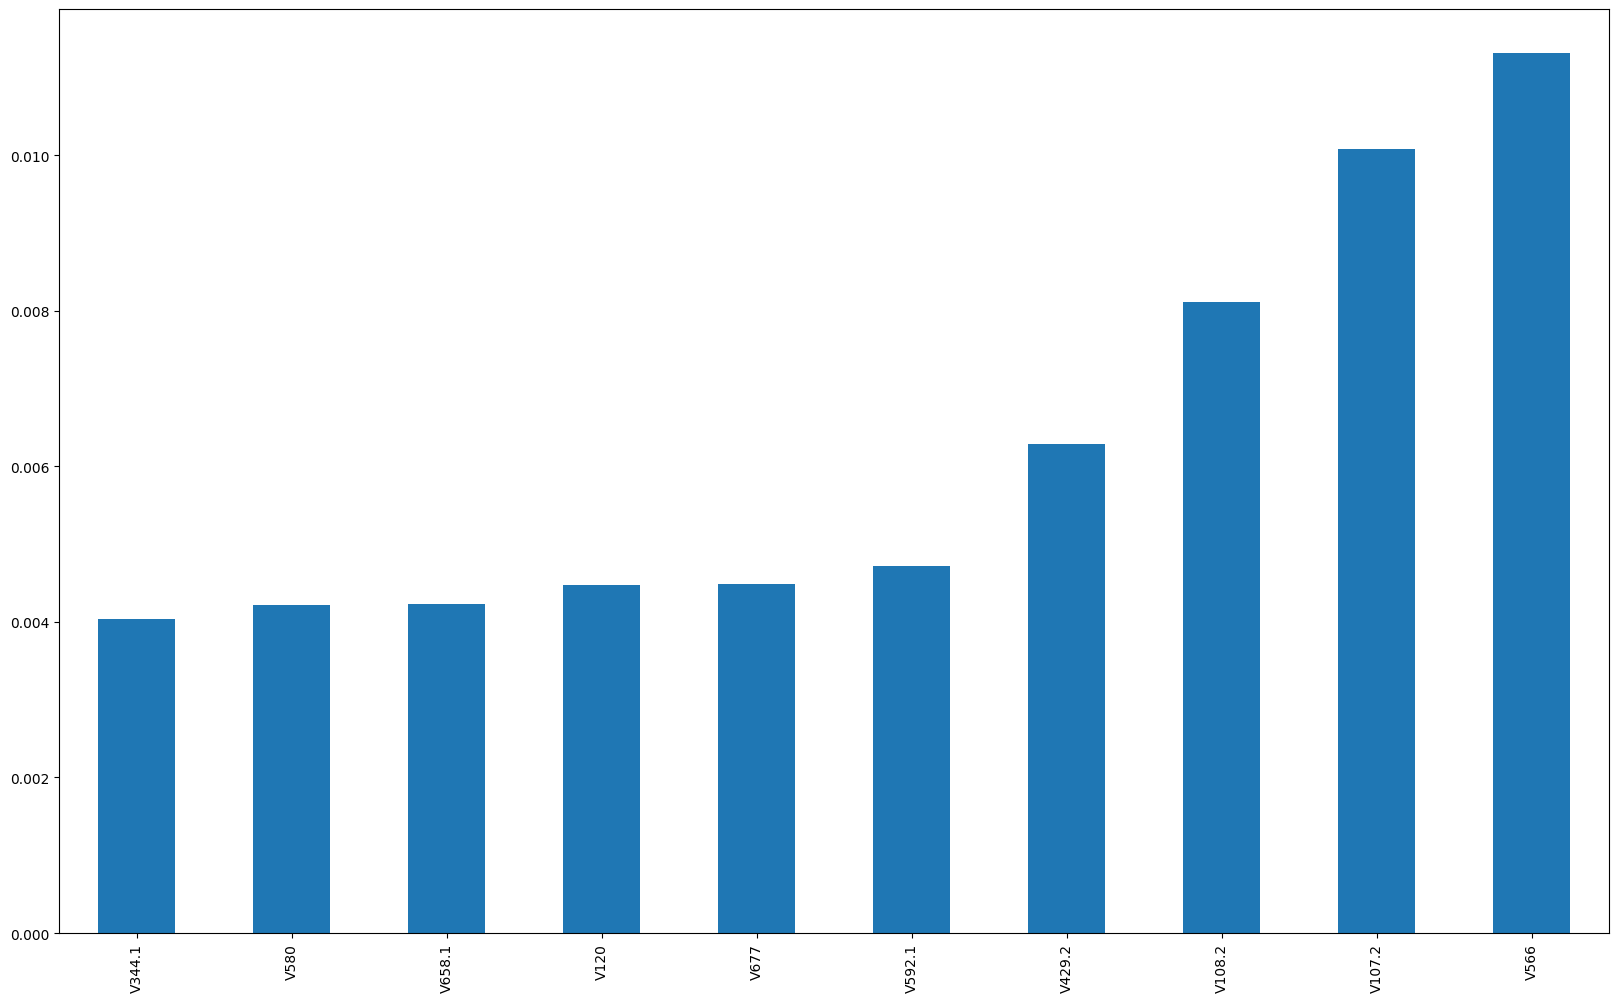

In [ ]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(regr.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (20,12))

In [ ]:
Turn all the lights offTurn all the lights offtoPlot = pd.DataFrame({'Model': ['Original NeST-VNN', 'Retrained NeST-VNN', 'Original Random Forest', 'Random Forerst', 'Original Elastic Net', 'Elastic Net'],
                       'Type': ['Published', 'Retrained', 'Published', 'Retrained', 'Published', 'Retrained'],
                       'Pearson': [0.334, 0.2887, 0.31, mean_pearson_rf, 0.236, mean_pearson_en]})
print(toPlot)

                    Model       Type   Pearson
0       Original NeST-VNN  Published  0.334000
1      Retrained NeST-VNN  Retrained  0.288700
2  Original Random Forest  Published  0.310000
3          Random Forerst  Retrained  0.378344
4    Original Elastic Net  Published  0.236000
5             Elastic Net  Retrained  0.374826


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (6).

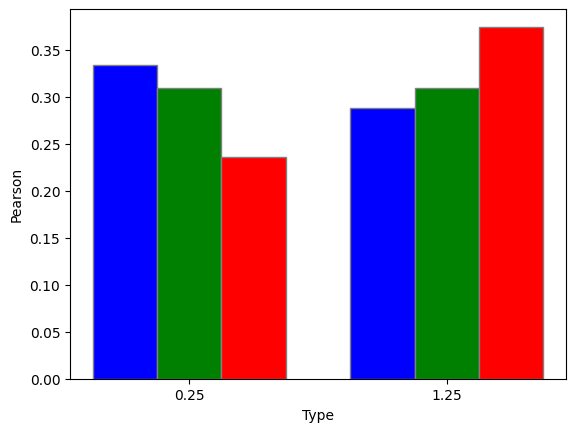

In [ ]:
# Separate data by Model and Type
nestvnn = toPlot[(toPlot['Model'].str.contains('NeST-VNN'))]
rf = toPlot[(toPlot['Model'].str.contains('Random Forest'))]
elastic_net = toPlot[(toPlot['Model'].str.contains('Elastic Net'))]

# Plotting
fig, ax = plt.subplots()

# Bar width
bar_width = 0.25

# X-axis positions for the bars
r1 = np.arange(len(nestvnn))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting bars
ax.bar(r1, nestvnn['Pearson'], color='b', width=bar_width, edgecolor='grey', label='NeST-VNN')
ax.bar(r2, rf['Pearson'], color='g', width=bar_width, edgecolor='grey', label='Random Forest')
ax.bar(r3, elastic_net['Pearson'], color='r', width=bar_width, edgecolor='grey', label='Elastic Net')

# Adding labels
ax.set_xlabel('Type')
ax.set_ylabel('Pearson')
ax.set_xticks([r + bar_width for r in range(len(nestvnn))])
ax.set_xticklabels(['Published', 'Retrained'] * 3)

# Adding legend
plt.legend()

# Adding title
plt.title('Pearson Scores by Model Type')

# Show plot
plt.show()

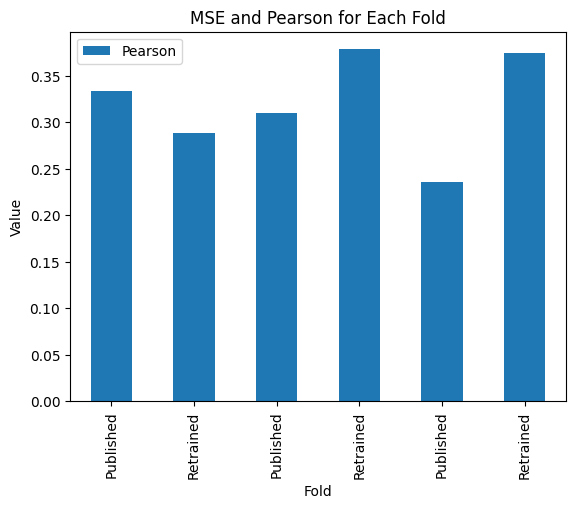

In [ ]:
fig, ax = plt.subplots()
#res.plot(kind='bar', x='Fold', y='MSE', color='blue', ax=ax, label='MSE')
#res.plot(kind='bar', x='Fold', y='Pearson', color='orange', ax=ax, label='Pearson')
toPlot.plot(kind='bar', x='Type', y='Pearson', ax=ax)
# Customizing the plot
plt.xlabel('Fold')
plt.ylabel('Value')
plt.title('MSE and Pearson for Each Fold')
plt.legend()

# Show plot
plt.show()

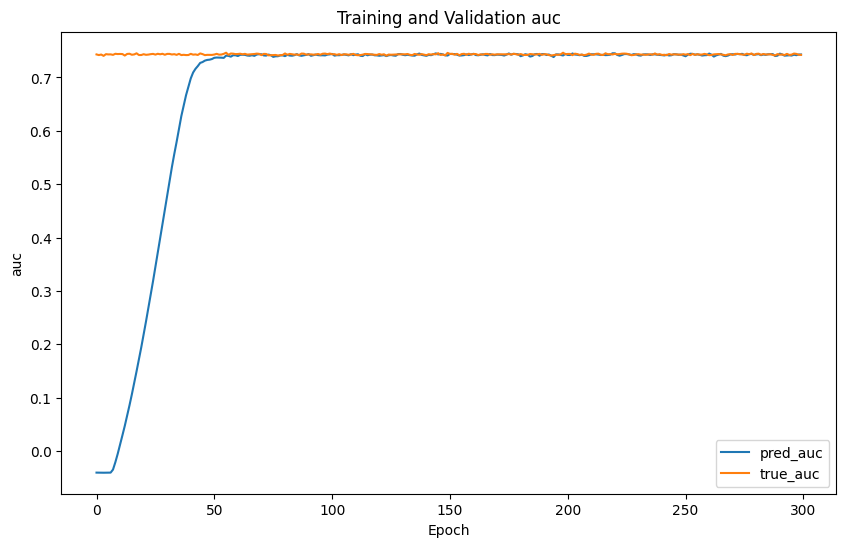

In [ ]:
# orange and blue graph that lucas wants

trainLog = pd.read_csv('train2.txt', sep='\t')

#min_loss = min(trainLog['train_loss'].min(), trainLog['val_loss'].min())
#max_loss = max(trainLog['train_loss'].max(), trainLog['val_loss'].max())

# Apply Min-Max scaling
#trainLog['scaled_train_loss'] = (trainLog['train_loss'] - min_loss) / (max_loss - min_loss)
#trainLog['scaled_val_loss'] = (trainLog['val_loss'] - min_loss) / (max_loss - min_loss)

# Plotting
#plt.figure(figsize=(10, 6))
#plt.plot(trainLog['epoch'], trainLog['scaled_train_loss'], label='Train Loss')
#plt.plot(trainLog['epoch'], trainLog['scaled_val_loss'], label='Validation Loss')
#plt.xlabel('Epoch')
#plt.ylabel('Scaled Loss')
#plt.title('Scaled Training and Validation Loss')
#plt.legend()
#plt.show()

##### unscaled ####

epochs = trainLog['epoch']
pred_auc = trainLog['pred_auc']
true_auc = trainLog['true_auc']

plt.figure(figsize=(10, 6))
plt.plot(epochs, pred_auc, label='pred_auc')
plt.plot(epochs, true_auc, label='true_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Training and Validation auc')
plt.legend()
plt.show()